# Обучение модели 

## Библиотеки



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, random
from tqdm.notebook import tqdm
from IPython import display
from datetime import datetime

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Подключение к google drive
from google.colab import drive
drive.mount('/content/drive1')

Mounted at /content/drive1


## Загрузка файлов

Загрузка таблицы соответствия [id полигона - фото], загрузка и распаковка архива с фотографиями. 

In [ ]:
# Путь к таблице img.csv
PATH_TO_CSV = '/content/drive1/MyDrive/Colab Notebooks/Большая Тройка/img.csv'
data = pd.read_csv(PATH_TO_CSV, sep=';',)

dataimg = data['img'].values
datapla = data['platform_id'].values

dataurl = []
for i in range(len(dataimg)):
    dataurl.append(str(datapla[i])+'/'+dataimg[i])

data.insert(1, 'url', dataurl)

datan = np.column_stack((data['platform_id'].values, data['url'].values, data['type'].values))

In [ ]:
import zipfile
# Путь к архиву с фотографиями
PATH_TO_ZIP = '/content/drive1/MyDrive/Colab Notebooks/Большая Тройка/CHEREP.zip'
fantasy_zip = zipfile.ZipFile(PATH_TO_ZIP)
fantasy_zip.extractall('/content/k1')
fantasy_zip.close()

In [ ]:
directory = "/content/k1/CHEREP"

import os.path
datann = []
for i in range(len(datan)):
    if datan[i][2]=='after' and datan[i+1][2]=='before' and datan[i][0]==datan[i+1][0]:
        if os.path.exists(directory+'/'+datan[i][1]) and os.path.exists(directory+'/'+datan[i+1][1]):
            datann.append(datan[i][1])
            datann.append(datan[i+1][1])
print(len(datann))

79132


### Подготовка датасета

`datann` - это список со строковыми переменными вида: 

['177928/saved-20190730_0756_15311.jpg',

 '177928/saved-20190730_0755_15521.jpg',

 '177941/saved-20190730_0740_07218.jpg',

 '177941/saved-20190730_0739_03703.jpg',
 
 ....]
 

#### Разбиение на train/val/test по полигонам

В датасете содержится 39566 пар фото до/после для 100 уникальных id полигонов. Сделаем разбиение на test, val, train по полигонам (а не просто случайным образом) в соотношении 70-15-15 по количеству полигонов. Например, в pairs_val будут пары для 15 уникальных полигонов. 

В этом датасете количество пар для разных id примерно одного порядка (ок. 400), поэтому в при таком разбиениии размеры test, val, train будут примерно в соотношении 70-15-15 и по количеству пар тоже.

Так мы сможем избежать data leakage, который происходит при случайном разбиении из-за того, что сеть видит при обучении те же полигоны, что и в тесте, пусть и в другой день.

In [ ]:
import pandas as pd
np.random.seed(42)

pairs_all = np.array(datann).reshape(-1, 2)

# Создаём dataframe со столбцом 'id'
pairs_dataframe = pd.DataFrame(pairs_all, columns=['before', 'after'])
pairs_dataframe['id'] = pairs_dataframe.apply(lambda x: int(x['before'][:6]), axis=1)
# Находим список всех уникальных ids
all_ids = pairs_dataframe['id'].unique()


# Случайно выбираем 15+15 id полигонов для test+val
test_val_ids = np.random.choice(all_ids, size=30, replace=False)
# Train ids = все оставшиеся id в all_ids
train_ids = [i for i in all_ids if i not in test_val_ids]

# Случайно выбираем 15 id полигонов для test из test+val
test_ids = np.random.choice(test_val_ids, size=15, replace=False)
# Val ids = все оставшиеся id в test_val_ids
val_ids = [i for i in test_val_ids if i not in test_ids]

print(test_ids, val_ids, train_ids)

[184213 178014 177769 178201 178451 178197 177939 185618 185619 169004
 177627 178658 185700 177943 184081] [177942, 177628, 182900, 177948, 178264, 177766, 182905, 177928, 177958, 178476, 177923, 184250, 171459, 178274, 178448] [177941, 183822, 177927, 169017, 169018, 177765, 177630, 183551, 168999, 177960, 177772, 177959, 183040, 177770, 178463, 177917, 178312, 177946, 177620, 177619, 178704, 185587, 178453, 178456, 185574, 178270, 177878, 177965, 177949, 177963, 177979, 185571, 178739, 177953, 177952, 177660, 177703, 182976, 177839, 184186, 177784, 177933, 178287, 177934, 170287, 169019, 183664, 177912, 177710, 177665, 169341, 169954, 169682, 185907, 169145, 178481, 169473, 184029, 177940, 178444, 177924, 178468, 178459, 178194, 178447, 178450, 183868, 183826, 177962, 177961]


In [ ]:
# Создаём train, val, test датафреймы только с нужными id
train_dataframe = pairs_dataframe[pairs_dataframe['id'].isin(train_ids)]
val_dataframe = pairs_dataframe[pairs_dataframe['id'].isin(val_ids)]
test_dataframe = pairs_dataframe[pairs_dataframe['id'].isin(test_ids)]

# Удаляем столбец с id (не используется для создания Dataset)
pairs_train = np.array(train_dataframe[['before', 'after']])
pairs_val = np.array(val_dataframe[['before', 'after']])
pairs_test = np.array(test_dataframe[['before', 'after']])

print(f'Train: {len(pairs_train)}, val: {len(pairs_val)}, test: {len(pairs_test)}')

Train: 27168, val: 6217, test: 6181


#### Создание DataLoader

In [ ]:
class PolygonDataset(Dataset):
    """Custom Polygon Dataset dataset."""

    def __init__(self, list_pairs, root_dir, transform=None):
        """
        Args:
            list_pairs (np.array: (n_pairs , 2)): Path to the images.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.good_pairs = list_pairs
        self.root_dir = root_dir
        self.transform = transform

        # Создаём неправильные пары:
        datann = list(list_pairs.reshape(-1)) # возвращаемся к 1D-списку 
        n_max = len(datann)
        datan_rand = [datann[0]]
        while len(datan_rand) < n_max:
            n = random.randint(0, len(datann) - 1)
            if datann[n][:6] != datan_rand[-1][:6]:
                datan_rand.append(datann[n])
        self.bad_pairs = np.array(datan_rand).reshape(-1, 2)

        # Создаём метки для правильных (1) и неправильных (0) пар в виде 
        # дополнительного последнего столбца:
        self.good_pairs = np.insert(self.good_pairs, 2, 
                                    np.ones(len(self.good_pairs)), axis=1)
        self.bad_pairs = np.insert(self.bad_pairs, 2, 
                                   np.zeros(len(self.good_pairs)), axis=1)
        
        # Конкатенируем правильные и неправильные пары (+ метки) в один массив
        self.pairs = np.concatenate((self.good_pairs, self.bad_pairs), axis=0)

        # Перемешать порядок, чтобы правильные и неправильные пары чередовались
        np.random.shuffle(self.pairs)


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name_0 = os.path.join(self.root_dir, self.pairs[idx, 0])
        img_name_1 = os.path.join(self.root_dir, self.pairs[idx, 1])

        image_0 = Image.open(img_name_0)
        image_1 = Image.open(img_name_1)

        if self.transform is not None:
            image_0 = self.transform(image_0)
            image_1 = self.transform(image_1)

        label = torch.tensor(float(self.pairs[idx, 2]))
        label = torch.unsqueeze(label,0)

        return image_0, image_1, label

In [ ]:
# Create the instances of PolygonDataset:
mobilenetv3_transform = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.CenterCrop(256),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])
train_dataset = PolygonDataset(pairs_train, directory, mobilenetv3_transform)
val_dataset = PolygonDataset(pairs_val, directory, mobilenetv3_transform)
test_dataset = PolygonDataset(pairs_test, directory, mobilenetv3_transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                              num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                              num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                              num_workers=2, pin_memory=True)

#### Визуализация

In [ ]:
def prepare_image(img_torch, 
                  mean=np.array([0.485, 0.456, 0.406]),
                  std=np.array([0.229, 0.224, 0.225])):
    # From PyTorch to Numpy
    # img_numpy = img_torch.numpy().transpose(1, 2, 0)
    img_numpy = img_torch.cpu().numpy().transpose(1, 2, 0)

    # Unnormalize (for correct color display)
    img_numpy = std * img_numpy + mean
    img_numpy = np.clip(img_numpy, 0, 1)

    return img_numpy

def plot_pair(img0, img1, label, pred=None):
    img0 = prepare_image(img0)
    img1 = prepare_image(img1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for img, ax in zip((img0, img1), axs.flatten()):
        ax.imshow(img)
        ax.set_axis_off()
    if pred is None:
        fig.suptitle(f'Label: {label.cpu().numpy()}', fontsize=15)
    else:
        fig.suptitle(f'Label: {label.cpu().numpy()}, prediction: {pred.cpu().numpy()}', fontsize=15)

In [ ]:
for imgs0, imgs1, labels in train_dataloader:
    print(f'Images_0.shape: {imgs0.shape}')
    print(f'Images_1.shape: {imgs1.shape}')
    print(f'labels.shape: {labels.shape}')

    for i in range(len(imgs0)):
        plot_pair(imgs0[i], imgs1[i], labels[i])
    break

Output hidden; open in https://colab.research.google.com to view.

## Сеть

#### Необходимые классы и функции

На вход сети поступает два изображения, для которых должно быть предсказано, являются ли они парой до/после для одного и того же полигона в один и тот же день (`label: 1`) или нет (`label: 0`).

Архитектура сети основана на MobileNetv3. Оба изображения подаются поочередно на вход feature_extractor части сети, после которой на выходе для каждого изображения имеем тензор размера `[batch_size, 1280, 7, 7]`. Затем каждый такой тензор проходит через Adaptive Average Pooling, что после операции `torch.flatten()` даёт тензор размера `[batch_size, 1280]`. Два таких тензора конкатенируются вместе, и полученный тензор размера `[batch_size, 2*1280]` подаётся на вход к линейным слоям (`linear_layers`) с nn.Sigmoid() в конце.

In [ ]:
import torchvision.models as models

class MyMobileNet(nn.Module):   
    def __init__(self, num_features_fc=1280, num_classes=1):
        super(MyMobileNet, self).__init__()

        mobilenet = models.mobilenet_v3_large(pretrained=True)
        mobilenet._modules.pop('classifier')
        self.mobilenet_features = nn.Sequential(mobilenet._modules)
        mobilenet = None


        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=2 * 960, out_features=num_features_fc, bias=True),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(num_features_fc, num_classes),
            nn.Sigmoid(),
        )

    # Defining the forward pass    
    def forward(self, imgs0, imgs1):

        x0 = self.mobilenet_features(imgs0) # out: [batch_size, 1280, 7, 7]
        x0 = nn.functional.adaptive_avg_pool2d(x0, (1, 1))  # out: [batch_size, 1280, 1, 1]
        x0 = torch.flatten(x0, 1) # out: [batch_size, 1280]

        x1 = self.mobilenet_features(imgs1) # out: [batch_size, 1280, 7, 7]
        x1 = nn.functional.adaptive_avg_pool2d(x1, (1, 1))  # out: [batch_size, 1280, 1, 1]
        x1 = torch.flatten(x1, 1) # out: [batch_size, 1280]

        x = torch.cat((x0, x1), dim=1) # out: [batch_size, 2*1280]
        x = self.linear_layers(x) # out: [batch_size, 1]
        return x

In [ ]:
def train_on_custom_dataset(train_dataloader, val_dataloader, model, optimizer, scheduler, n_epochs=10):
# Train `model` on `train_dataloader` using `optimizer`. Use best-accuracy settings.

    loss_function = nn.BCELoss()

    train_losses = []
    val_epochs = [] # the epochs when val metrics are calculated
    val_accuracys, val_losses = [], []
    best_val_accuracy = 0.0
    
    for epoch in tqdm(range(n_epochs)):

        running_loss = 0.0
        processed_size = 0

        model.train()
        for i, batch in enumerate(tqdm(train_dataloader)):
            # get labels and images in current batch
            imgs0, imgs1, labels = batch
            
            # zero gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            preds = model(imgs0.to(DEVICE), imgs1.to(DEVICE))
            loss = loss_function(preds, labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            # current loss value:
            running_loss += loss.item() * imgs0.size(0)
            processed_size += imgs0.size(0) 

        train_losses.append(running_loss / processed_size)
        
        scheduler.step()
        
        # checkpoint every 2th epoch (starting with the first)
        if epoch % 2 == 0 or epoch == (n_epochs - 1):
            val_acc, val_loss = validate(val_dataloader, model)

            val_epochs.append(epoch + 1)
            val_accuracys.append(val_acc)
            val_losses.append(val_loss)

            if val_acc >= best_val_accuracy:
                data_name = datetime.now().isoformat(timespec='seconds')
                checkpoint_path = '/content/drive1/MyDrive/Colab Notebooks/Большая Тройка/'
                checkpoint_name = checkpoint_path + data_name + '_' + str(round(val_acc, 5)) + '.pth'

                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'loss': train_losses[-1],
                            }, 
                            checkpoint_name)

                best_val_accuracy = val_acc

                
        display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
        ax1.plot(range(1, len(train_losses) + 1), train_losses, label='train')
        ax1.plot(val_epochs, val_losses, label='val')
        ax1.set_xlabel('# epochs')
        ax1.set_ylabel('loss')
        ax1.set_title(f'Current train loss {train_losses[-1]:.4f}, last val loss {val_losses[-1]:.4f}')
        ax1.legend()

        ax2.plot(val_epochs, val_accuracys, label='val')
        ax2.set_xlabel('# epochs')
        ax2.set_ylabel('accuracy, in decimals')
        ax2.set_title(f'Best accuracy {(best_val_accuracy * 100):.3f}, Last accuracy {(val_accuracys[-1] * 100):.3f}')
        ax2.legend()

        fig.savefig(checkpoint_path + 'last_results.png')

        plt.show()

In [ ]:
def validate(dataloader, model):
# Run `model` through all samples in `dataloader`, compute accuracy and loss.

    loss_function = nn.BCELoss()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.eval()
    for batch in tqdm(dataloader):
        imgs0, imgs1, labels = batch
        imgs0 = imgs0.to(DEVICE)
        imgs1 = imgs1.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad(): 
            preds = model(imgs0, imgs1)
        loss = loss_function(preds, labels)

        running_loss += loss.item() * imgs0.size(0) # weighted sum, weight=batch_size
        running_corrects += torch.sum(torch.round(preds) == labels.data).item()
        processed_size += imgs0.size(0) 
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size

    return val_acc, val_loss

In [ ]:
def load_weights(model, checkpoint_path):
    # Initialize `model`'s weights from `checkpoint_path` file.
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

### 1. Обучаем последние слои сети (веса в backbone заморожены)

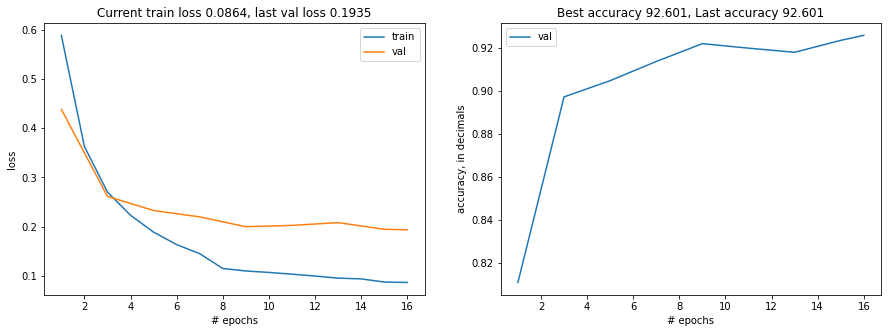

In [ ]:
learning_rate = 1e-4
n_epochs = 16

# Initialize model
model = MyMobileNet().to(DEVICE)

# Froze all the layers except the ones we created 
for name, param in model.named_parameters():
    if name in ['linear_layers.0.weight',
                'linear_layers.0.bias',
                'linear_layers.3.weight',
                'linear_layers.3.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.2)

# Train and validation loop
train_on_custom_dataset(train_dataloader, val_dataloader, model, optimizer, scheduler, n_epochs=n_epochs)

### 2. Дообучаем все слои сети

In [ ]:
# Load the model checkpoint from which we will continue training
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model_from_file = MyMobileNet().to(DEVICE)
path_to_checkpoint = '/content/drive1/MyDrive/Colab Notebooks/Большая Тройка/mobilenetv3_3_freezed_backbone/2021-06-24T16:12:35_0.92601.pth'

load_weights(model_from_file, path_to_checkpoint)

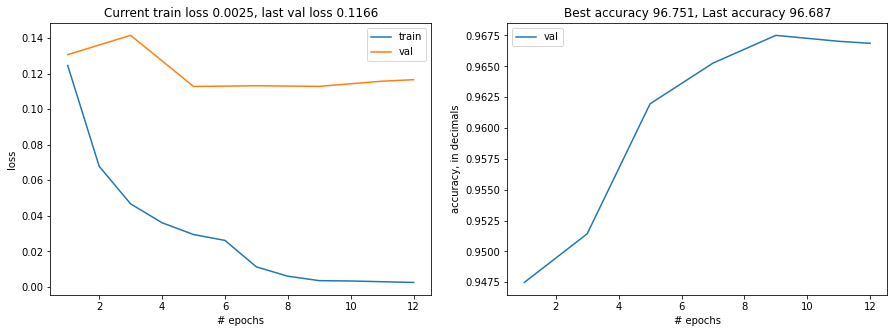

In [ ]:
learning_rate = 1e-4
n_epochs = 12

# Unfroze all the layers
for name, param in model_from_file.named_parameters():
    param.requires_grad = True

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model_from_file.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 8], gamma=0.2)

# Train and validation loop
train_on_custom_dataset(train_dataloader, val_dataloader, model_from_file, optimizer, scheduler, n_epochs=n_epochs)

# Оценивание обученной модели

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model_final = MyMobileNet().to(DEVICE)
path_to_final_model = '/content/drive1/MyDrive/Colab Notebooks/Большая Тройка/Photo_comparison_pytorch/model_0.9657.pth'

load_weights(model_final, path_to_final_model) 

Оценим метрики на тестовой выборке:

In [ ]:
test_acc, test_loss = validate(test_dataloader, model_final)
print(f'Accuracy on test set: {test_acc}')


Accuracy on test set: 0.9661058081216631


Рассмотрим матрицу ошибок:

In [ ]:
from sklearn.metrics import confusion_matrix

def my_confusion_matrix(model, data_loader):
    model.eval()

    y_vals = []
    y_predictions = []

    for batch in tqdm(data_loader):
        imgs0, imgs1, labels = batch
        imgs0 = imgs0.to(DEVICE)
        imgs1 = imgs1.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad(): 
            preds = model(imgs0, imgs1)
            preds = torch.round(preds)

        y_predictions.extend(preds.tolist())
        y_vals.extend(labels.tolist())
    
    tn, fp, fn, tp = confusion_matrix(y_vals, y_predictions).ravel()

    return tn, fp, fn, tp

In [ ]:
my_confusion_matrix(model_final, test_dataloader)

(5905, 276, 143, 6038)

Оценим вес модели с помощью библиотеки torchsummary:

In [ ]:
from torchsummary import summary

summary(model_final, [(3, 224, 224), (3, 224, 224)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
          Identity-9         [-1, 16, 112, 112]               0
 InvertedResidual-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]           1,024
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
           Conv2d-14           [-1, 64,

Визуализируем несколько предсказаний:

In [ ]:
for imgs0, imgs1, labels in test_dataloader:
    model_final.eval()

    imgs0 = imgs0.to(DEVICE)
    imgs1 = imgs1.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad(): 
        preds = model_final(imgs0, imgs1)

    for i in range(len(imgs0)):
        plot_pair(imgs0[i], imgs1[i], labels[i], preds[i])
    break